<a href="https://colab.research.google.com/github/jyotidabass/Multi-scale-retinex-with-color-restoration/blob/main/Multi_scale_retinex_with_color_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!git clone https://github.com/adiMallya/retinex

Cloning into 'retinex'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 77 (delta 31), reused 52 (delta 17), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [14]:
import numpy as np
import cv2
from skimage import img_as_float64

def singleScale(img,sigma):
    """
    Single-scale Retinex
    
    Parameters :
    img : input image
    sigma : the standard deviation in the X and Y directions, for Gaussian filter
    """

    ssr = np.log10(img) - np.log10(cv2.GaussianBlur(img,(0,0),sigma))
    return ssr

def multiScale(img,sigmas : list):
    """
    Multi-scale Retinex
    
    Parameters :
    img : input image
    sigma : list of all standard deviations in the X and Y directions, for Gaussian filter
    """

    retinex = np.zeros_like(img)
    for s in sigmas:
        retinex += singleScale(img, s)

    msr = retinex/len(sigmas)
    return msr

def crf(img, alpha, beta):
    """
    CRF (Color restoration function)
    Parameters :
    img : input image
    alpha : controls the strength of the nonlinearity
    beta : gain constant
    """
    img_sum = np.sum(img,axis=2,keepdims=True)

    color_rest = beta * (np.log10(alpha*img) - np.log10(img_sum))
    return color_rest


def MSRCR(img, sigmas :list, alpha, beta, G, b):
    """
    MSRCR (Multi-scale retinex with color restoration)
    Parameters :
    img : input image
    sigmas : list of all standard deviations in the X and Y directions, for Gaussian filter
    alpha : controls the strength of the nonlinearity
    beta : gain constant
    G : final gain
    b : offset
    """
    img = img_as_float64(img)+1

    img_msr = multiScale(img, sigmas)    
    img_color = crf(img, alpha, beta)    
    img_msrcr = G * (img_msr*img_color + b)
    
    
    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                                (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                                255

    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    
    return img_msrcr

In [15]:
import os
import cv2 
import argparse
from skimage import img_as_float64
import matplotlib.pyplot as plt


def read_show(file_path,file,show=False):
    '''
    A function to read an image and return a RGB version of it,
    also display the image.
    Args:
    file_path : the path/location of the input file
    file :  input filename   
    show :  if set "True" displays the image
    '''

    img = cv2.imread(os.path.join(file_path,file))
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    
    if show==True:
        plt.imshow(img)
        plt.xticks([]),plt.yticks([])
        plt.show()
    return img


def plot_hist(orig_img, enh_img, hist=False, save=False, fname=None):
    '''
    A function to display original and enhanced images.
    Args:
    origin_img : input image
    enh_img : MSRCR output  
    save : FALSE(default); Set it to TRUE to save the output to assets.
    '''
    if hist :
        fig, ax = plt.subplots(2,2, figsize=(20,15))

        ax[0,0].imshow(orig_img)
        ax[0,0].set_xticks([])
        ax[0,0].set_yticks([])
        ax[0,0].set_title('Original',fontsize=25)
        ax[1,0].hist(orig_img.ravel(),256,[0,256])

        ax[0,1].imshow(enh_img)
        ax[0,1].set_xticks([])
        ax[0,1].set_yticks([])
        ax[0,1].set_title('Enhanced',fontsize=25)
        ax[1,1].hist(enh_img.ravel(),256,[0,256])

        fig.suptitle('Multi-scale retinex  with color restoration', fontsize=30, y=1.05)
        fig.tight_layout()

    else :
        fig, ax = plt.subplots(1,2, figsize=(15,8))

        ax[0].imshow(orig_img)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title('Original',fontsize=25)
        ax[1].imshow(enh_img)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title('Enhanced',fontsize=25)

        fig.suptitle('Multi-scale retinex  with color restoration', fontsize=30, y=1.05)
        fig.tight_layout()

    
    if save:
        if fname is not None:
            save_file = os.path.join('assets', fname) 
            plt.savefig(save_file,bbox_inches='tight',dpi=72)
            plt.close(fig)

    

def checker(path):
    if os.path.basename is None:
        raise argparse.ArgumentTypeError('File name not included in the path.')

    if os.path.basename not in os.path.dirname:
        raise argparse.ArgumentTypeError(f'{os.path.basename} doesn\'t exist in given path')
    return

In [21]:
import os
%matplotlib inline
PATH = "/content/retinex/Data"

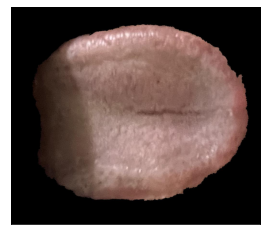

In [22]:
img_list = os.listdir(PATH)

#read_show() is a helper function, that takes the PATH and file name and displays the image
image = read_show(PATH,img_list[0],show=True)

In [30]:
config='/content/retinex/src/config.py'
SIGMA_LIST = [15, 80, 250]
ALPHA = 125.0
BETA = 46.0
G = 5.0
OFFSET = 25.0 


In [31]:
msrcr_img = MSRCR(image,SIGMA_LIST,ALPHA,BETA,G,OFFSET)

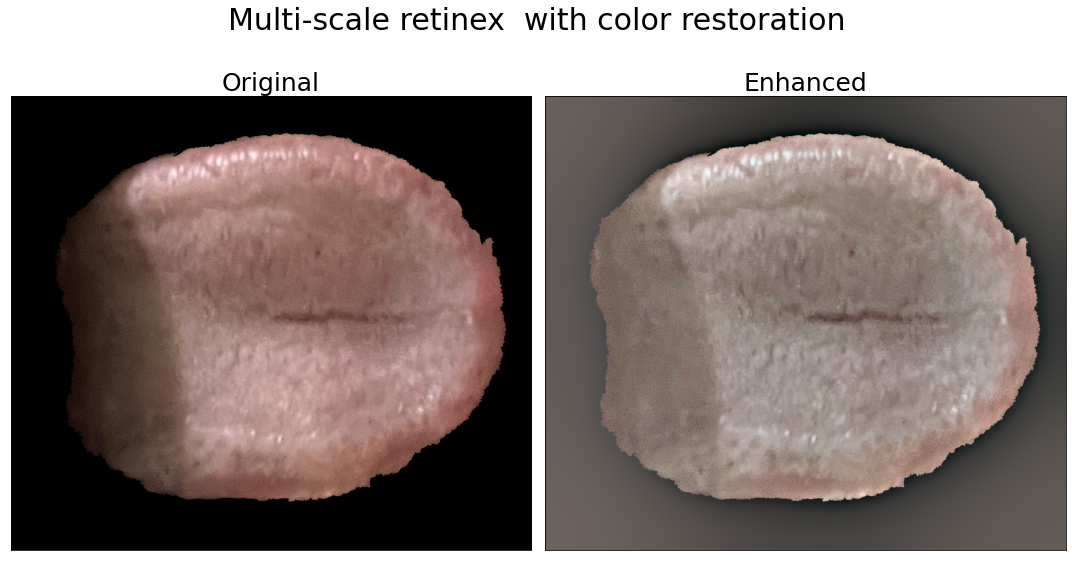

In [32]:
#plot_hist() takes both the original and enhanced image and plots them, you could even plot their histograms by setting hist=True.
plot_hist(image, msrcr_img, hist=False)